<a href="https://colab.research.google.com/github/MLMario/mariogj1987/blob/main/Predicting_Carbon_Emission_in_Rwanda_using_Chat_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Predicting CO2 emission with ChatGPT Guidance

This exercise is trying to leverage chat GPT to take me through learning how to predict a time series using machine learning techniques, which I'm not an expert in.  

I'm using ChatGpT - v4 code interpreter as of 09/2023. Initially I intendent to follow its guidance as close as possible, but quickly it became apparent that the longer the conversation and complex the problem, the harder was for ChatGPT to run code and make perfect advise. So a lot of debugging was actually needed.

If you are curious, the original conversations with ChatGPT are here:

1)[ First conversation (More EDA focus) ](https://chat.openai.com/share/af8d791e-d920-45ba-98d6-e800d2c40b56)

2) [Second conversion, more Model selection and Training focus](https://chat.openai.com/share/197f24c2-326b-4ccc-abf6-ae90baa0be48)

3) [third conversation, mode focus on training a LSTM model](https://chat.openai.com/share/b24f46d7-017c-4aec-a818-1afb14b2304f)

We will use [this](https://www.kaggle.com/competitions/playground-series-s3e20/overview) competition which is a simple one with no price money. The objective is to predict emissions in Rwanda

## Importing data from Kaggle API and setting libraries

In [ ]:
import os
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


import xgboost as xgb




In [ ]:
from google.colab import files
uploaded = files.upload()



Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c playground-series-s3e20

 90% 44.0M/48.9M [00:01<00:00, 38.5MB/s]
100% 48.9M/48.9M [00:01<00:00, 29.3MB/s]


In [ ]:
!unzip playground-series-s3e20.zip


Archive:  playground-series-s3e20.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
else:
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU
    print('Running on GPU ', gpus)
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on GPU  [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Number of accelerators:  1



### Identifying columns

I asked chat gpt to describe to me the datasets, it came up with a reasonable summary, and is seems to have properly understood the the CO2 emissions are the target variables. The summary was:


Here are the columns present in each dataset:

**Train dataset:**

The train dataset is quite extensive. It has columns related to:

ID, latitude, longitude, year, and week number.
Various metrics related to each of the gases/features like Sulphur Dioxide, Carbon Monoxide, Nitrogen Dioxide, etc. Each of these metrics has sub-features associated with them, such as column number density, sensor azimuth angle, and solar zenith angle, among others.
The list is quite long, so I've just highlighted a few of them here.

**Test dataset**

ID, latitude, longitude, year, and week number.
Similar metrics as the train dataset for each of the gases/features, but without the target CO2 emissions column.

**Sample_submission dataset**

ID_LAT_LON_YEAR_WEEK: An identifier for each prediction.
Emission: The predicted CO2 emission value.



## Exploratory Data Analysis

as suggested by chat gtp we are going to start with an exploratory analysis to understand which variables might help with the prediction. we will ask it to only use the train dataset

The following data analysis is based on Chat GPT suggestions and some **LIGHT**.

**Here we can already see the limitations of just relying on the AI, this EDA is not exactly the best for a time series-based dataset**



In [ ]:
# Display basic statistics for each column
train.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


In [ ]:
test.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
count,24353.000000,24353.000000,24353.0,24353.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,...,24187.000000,24187.000000,24187.000000,24187.000000,24187.000000,24187.000000,24187.000000,24187.000000,24187.000000,24187.000000
mean,-1.891072,29.880155,2022.0,24.000000,0.000014,0.792570,0.000009,0.139218,9.298052,36.174307,...,52291.369823,5850.560884,58914.750636,4876.144989,18.219421,0.256019,-15.910583,40.078944,-82.411205,27.984961
std,0.694532,0.810387,0.0,14.142426,0.000234,0.168043,0.000170,0.079865,67.148199,14.156478,...,8474.312135,1385.456558,9137.478850,1363.987819,12.276853,0.046614,31.296817,6.289530,35.684048,4.446146
min,-3.299000,28.228000,2022.0,0.000000,-0.000977,0.339845,-0.000775,0.000000,-106.809900,0.099606,...,22968.371094,1748.440552,26601.015625,1108.339359,1.758491,0.015563,-106.794670,0.181503,-148.381015,14.451874
25%,-2.451000,29.262000,2022.0,12.000000,-0.000122,0.678384,-0.000094,0.078934,-41.627297,26.577654,...,46443.513511,4891.547765,52564.911002,3919.961568,10.090358,0.229489,-35.621207,35.431041,-119.069505,24.359645
50%,-1.882000,29.883000,2022.0,24.000000,0.000007,0.763307,0.000004,0.138999,16.857963,37.310447,...,52026.814647,5813.010892,58725.298896,4828.621533,14.748459,0.257279,-12.945370,41.097947,-75.828261,28.389770
75%,-1.303000,30.471000,2022.0,36.000000,0.000137,0.872586,0.000104,0.200819,73.664560,45.972595,...,57814.509397,6780.095125,64998.470002,5793.453767,22.200969,0.287632,4.320550,44.186126,-46.573705,31.624962
max,-0.510000,31.532000,2022.0,48.000000,0.004110,1.696826,0.002701,0.299973,157.503026,66.243271,...,83092.004251,11840.539740,88543.121457,10840.539720,123.585268,0.507783,81.252467,65.118706,-22.295398,39.770470


### Missing Values Analysis and handling

- Prompting the AI to add a location feature will become handy

In [ ]:
# Concatenate latitude and longitude to create a 'location' column
train['location'] = train['latitude'].astype(str) + '_' + train['longitude'].astype(str)
test['location'] = test['latitude'].astype(str) + '_' + test['longitude'].astype(str)

# Display the first few rows of the updated train dataset
train[['ID_LAT_LON_YEAR_WEEK','latitude','longitude','location','year','week_no','emission']].head()


,ID_LAT_LON_YEAR_WEEK,latitude,longitude,location,year,week_no,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,-0.51_29.29,2019,0,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,-0.51_29.29,2019,1,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,-0.51_29.29,2019,2,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,-0.51_29.29,2019,3,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,-0.51_29.29,2019,4,4.347317


- As suggested we are starting with missiing values analysis

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
# Calculate the percentage of missing values for each column in the train dataset
missing_percentage = train.isnull().mean() * 100

# Filter columns with missing values and sort them
missing_values = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

missing_values


UvAerosolLayerHeight_aerosol_pressure                       99.444466
UvAerosolLayerHeight_solar_zenith_angle                     99.444466
UvAerosolLayerHeight_aerosol_height                         99.444466
UvAerosolLayerHeight_aerosol_optical_depth                  99.444466
UvAerosolLayerHeight_sensor_zenith_angle                    99.444466
UvAerosolLayerHeight_sensor_azimuth_angle                   99.444466
UvAerosolLayerHeight_solar_azimuth_angle                    99.444466
NitrogenDioxide_NO2_slant_column_number_density             23.183124
NitrogenDioxide_tropopause_pressure                         23.183124
NitrogenDioxide_tropospheric_NO2_column_number_density      23.183124
NitrogenDioxide_absorbing_aerosol_index                     23.183124
NitrogenDioxide_cloud_fraction                              23.183124
NitrogenDioxide_sensor_altitude                             23.183124
NitrogenDioxide_sensor_azimuth_angle                        23.183124
NitrogenDioxide_sens

In [ ]:
# Calculate the percentage of missing values for each column in the train dataset
missing_percentage_test = test.isnull().mean() * 100

# Filter columns with missing values and sort them
missing_values_test = missing_percentage_test[missing_percentage_test > 0].sort_values(ascending=False)

missing_values_test

UvAerosolLayerHeight_aerosol_pressure                       91.405576
UvAerosolLayerHeight_solar_zenith_angle                     91.405576
UvAerosolLayerHeight_aerosol_height                         91.405576
UvAerosolLayerHeight_aerosol_optical_depth                  91.405576
UvAerosolLayerHeight_sensor_zenith_angle                    91.405576
UvAerosolLayerHeight_sensor_azimuth_angle                   91.405576
UvAerosolLayerHeight_solar_azimuth_angle                    91.405576
SulphurDioxide_SO2_column_number_density_amf                25.220712
SulphurDioxide_SO2_column_number_density                    25.220712
SulphurDioxide_SO2_column_number_density_15km               25.220712
SulphurDioxide_solar_azimuth_angle                          25.220712
SulphurDioxide_sensor_zenith_angle                          25.220712
SulphurDioxide_sensor_azimuth_angle                         25.220712
SulphurDioxide_cloud_fraction                               25.220712
SulphurDioxide_SO2_s

There is a significant amount of missing values, based on the AI suggestion we ask the AI to:  

1. Drop columns with >90% missing values
2. As Suggested, we will impute values where needed, we will start with a simple forward fill method and fill anything. (I would prefer to use prophet to fill null values)

In [ ]:
# Columns to drop (those with more than 90% missing values)
cols_to_drop = missing_values[missing_values > 90].index

# Drop these columns from the train dataset
train_cleaned = train.drop(cols_to_drop, axis=1)
test_cleaned = test.drop(cols_to_drop, axis = 1)

In [ ]:
# Apply forward fill imputation on the train dataset
train_imputed = train_cleaned.fillna(method='ffill')

#HUMAN ADD: I added this cause the AI hasn't pick up on the fact we are using this test to make predictions down the line.

test_imputed = test_cleaned.fillna(method = 'ffill')


In [ ]:
# Check the remaining missing values after imputation
remaining_missing = train_imputed.isnull().sum().sum()

remaining_missing

12

In [ ]:
# Check the remaining missing values after imputation
remaining_missing = test_imputed.isnull().sum().sum()

remaining_missing

37

In [ ]:
# Apply backward fill imputation on the train dataset for the remaining missing values
train_imputed = train_imputed.fillna(method='bfill')
test_imputed = test_imputed.fillna(method = 'bfill')

# Check the remaining missing values after the second imputation
remaining_missing_after_bfill = train_imputed.isnull().sum().sum()

remaining_missing_after_bfill

0

In [ ]:
# Check the remaining missing values after the second imputation
remaining_missing_after_bfill = test_imputed.isnull().sum().sum()

remaining_missing_after_bfill

0

### EDA analysis




In [ ]:
descriptive_stats = train_imputed.describe().transpose()

descriptive_stats

,count,mean,std,min,25%,50%,75%,max
latitude,79023.0,-1.891072,0.694522,-3.299000,-2.451000,-1.882000,-1.303000,-0.510000
longitude,79023.0,29.880155,0.810375,28.228000,29.262000,29.883000,30.471000,31.532000
year,79023.0,2020.000000,0.816502,2019.000000,2019.000000,2020.000000,2021.000000,2021.000000
week_no,79023.0,26.000000,15.297155,0.000000,13.000000,26.000000,39.000000,52.000000
SulphurDioxide_SO2_column_number_density,79023.0,0.000050,0.000282,-0.000996,-0.000097,0.000025,0.000157,0.004191
SulphurDioxide_SO2_column_number_density_amf,79023.0,0.838251,0.187310,0.241822,0.707814,0.811569,0.946155,1.885239
SulphurDioxide_SO2_slant_column_number_density,79023.0,0.000037,0.000215,-0.000887,-0.000079,0.000020,0.000124,0.004236
SulphurDioxide_cloud_fraction,79023.0,0.160018,0.073079,0.000000,0.111216,0.164310,0.215033,0.299998
SulphurDioxide_sensor_azimuth_angle,79023.0,-7.074613,66.073641,-179.537059,-65.618790,-12.338517,72.453461,122.095200
SulphurDioxide_sensor_zenith_angle,79023.0,36.902615,14.696670,0.099237,27.484981,37.251624,47.668571,66.242012


This are the conclusion arrived by the AI:

-We can see variations in scale across features, which will be essential to note if we use models sensitive to feature scales (like linear regression or SVM).

-Some features have negative minimum values, which might be expected depending on the nature of the measurement.

-The target variable, emission, has a wide range, with a minimum of 0 and a maximum of about 3167.77.

**We proceed now to see the distribution of the target variable**

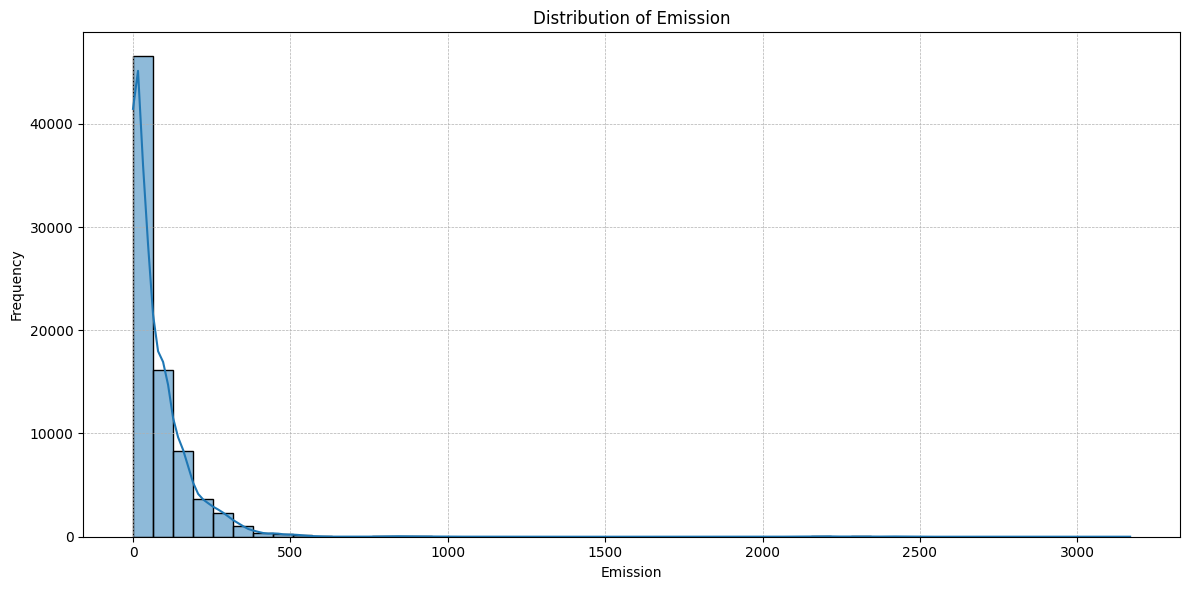

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axis
plt.figure(figsize=(12, 6))

# Plot the distribution of the target variable 'emission'
sns.histplot(train_imputed['emission'], bins=50, kde=True)

# Set the title and labels
plt.title('Distribution of Emission')
plt.xlabel('Emission')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()



The AI comes to this conclusions:

The distribution of the emission target variable displays the following characteristics:

- Right-skewed: Most of the data points are clustered on the left side, indicating that many locations have relatively lower emissions. However, there are locations with significantly higher emissions, leading to the long tail on the right.
- Presence of Outliers: The long tail suggests the potential presence of outliers or unique cases with exceptionally high emissions.
- Mode: The mode (peak of the distribution) is close to the lower end, reaffirming that many locations have low emissions.



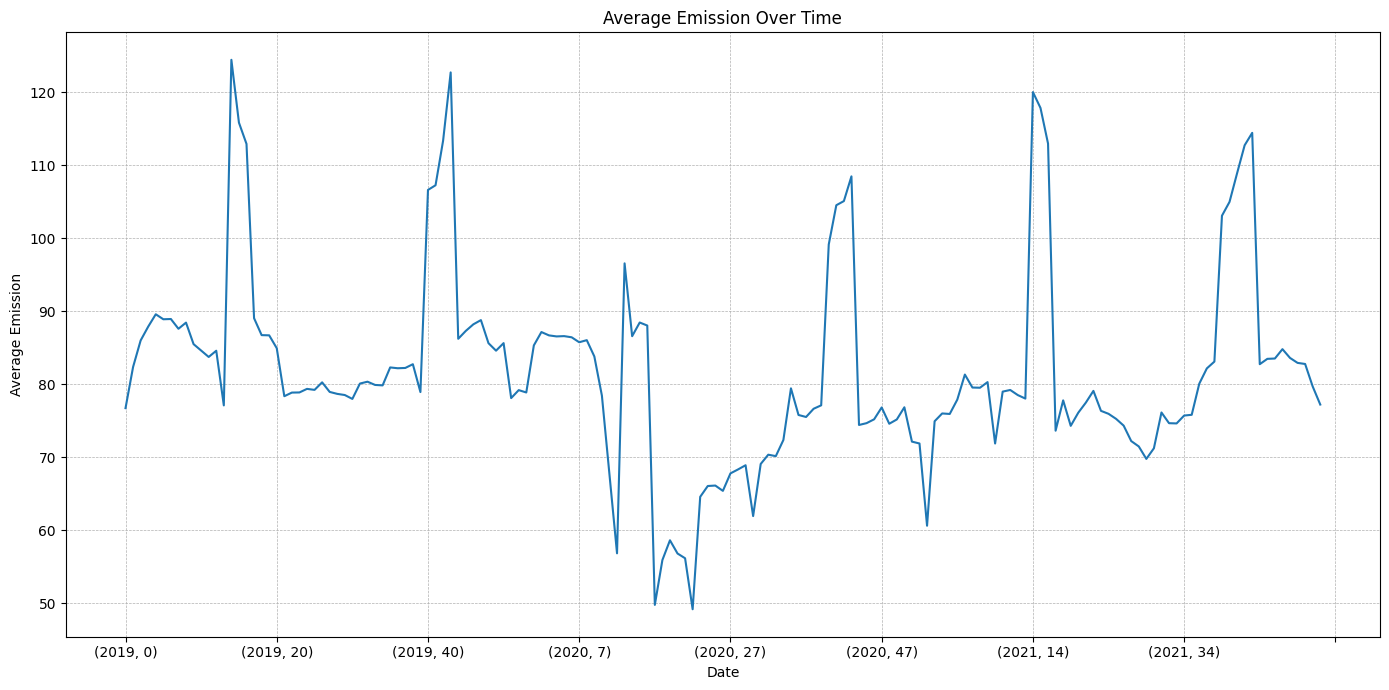

In [ ]:
# Group by 'date' and compute the average 'emission' for each date
avg_emission_over_time = train_imputed.groupby(['year','week_no'])['emission'].mean()

# Plotting the average emission over time
plt.figure(figsize=(14, 7))
avg_emission_over_time.plot()
plt.title('Average Emission Over Time')
plt.xlabel('Date')
plt.ylabel('Average Emission')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



Again the AI seems to arrive to particular conclusion. One this to note it that there seems to be some COVID effect on data that is not quite spotted by the AI. It's conclusion are:

- Trend: There seems to be a slight upward trend in emissions over time, indicating an increase in average emissions from 2019 to 2022.
- Seasonality: There's a clear cyclical pattern in the data, suggesting seasonality. Emissions seem to peak and dip at regular intervals throughout each year.
- Variability: The variance in emissions appears to be growing over time, with wider fluctuations in 2021 and 2022 compared to 2019.



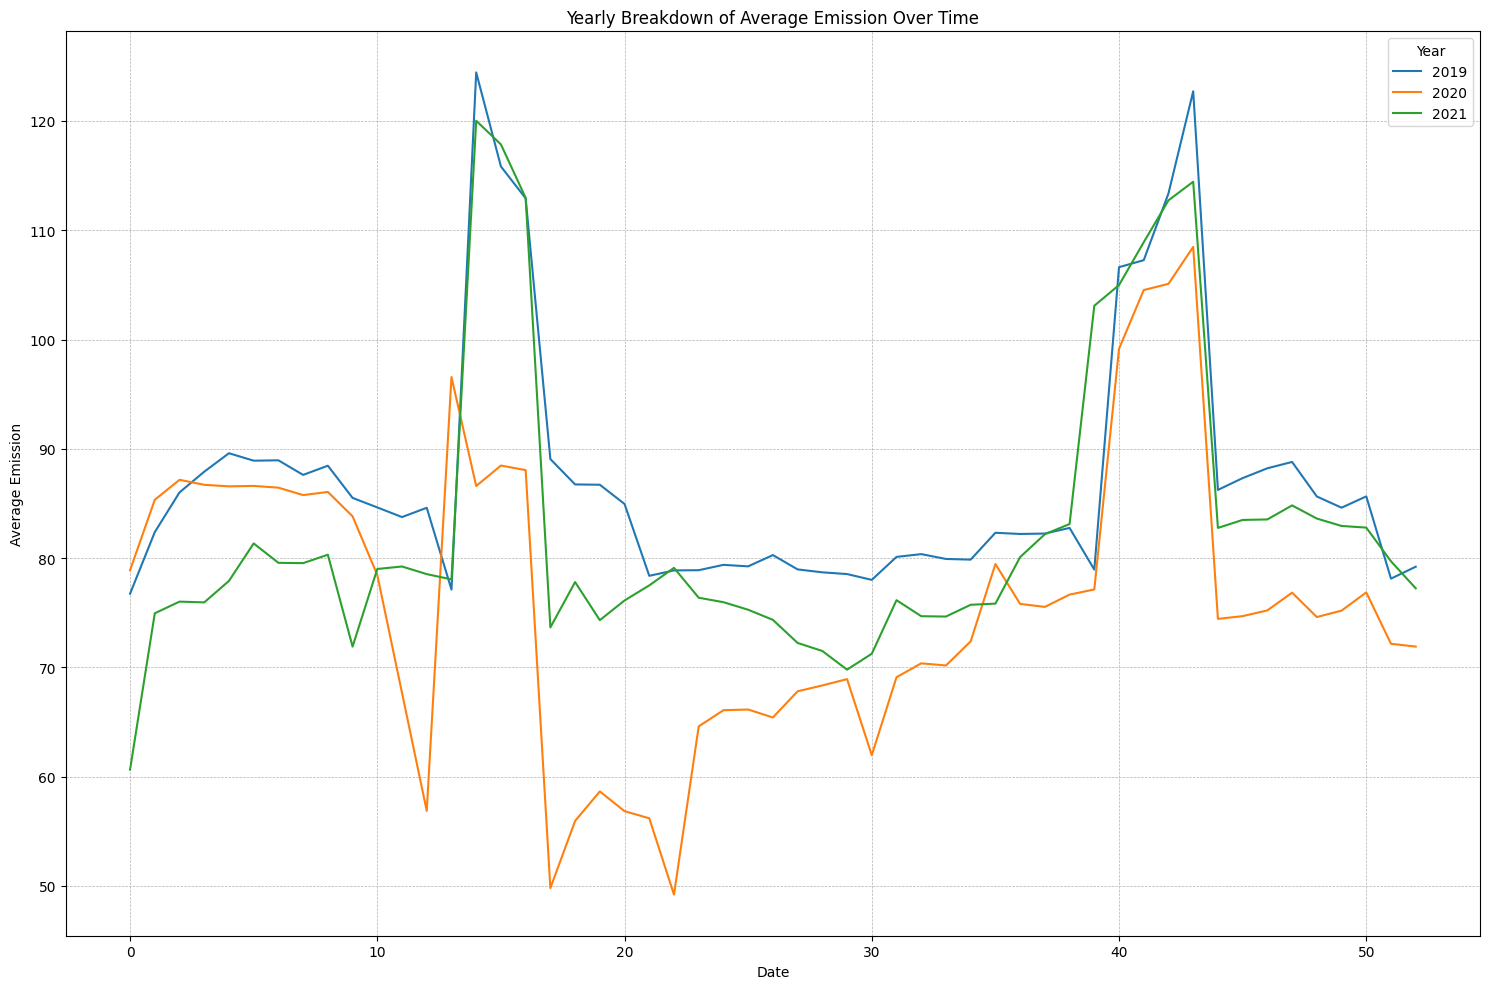

In [ ]:
plt.figure(figsize=(15, 10))

# List of unique years in the dataset
years = train_imputed['year'].unique()

# Plot average emission for each year
for year in years:
    subset = train_imputed[train_imputed['year'] == year].groupby('week_no')['emission'].mean()
    subset.plot(label=year)

# Set the title, labels, and legend
plt.title('Yearly Breakdown of Average Emission Over Time')
plt.xlabel('Date')
plt.ylabel('Average Emission')
plt.legend(title='Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

The AI comes to this conclusions:

- Consistent Seasonality: Each year appears to have a similar seasonal pattern, with certain times of the year consistently showing peaks and troughs in emissions. This regularity suggests there might be factors (e.g., agricultural cycles, weather patterns) that influence emissions in a predictable manner year after year.

- Increasing Trend: Confirming our earlier observation, the trend of emissions seems to be rising over the years. The peaks in 2021 and 2022 are higher than those in 2019 and 2020. This suggests an overall increase in emissions in the region over the years.

- Yearly Variability: There's a noticeable variability in emissions within each year. This intra-year fluctuation might be influenced by various factors and can be crucial for short-term forecasting.


We can see that its coming to a sort of correct but also wrong conclusion around the increasing trend. It's true that 2021 is increasing vs 2020, but 2020 was an atypical (covid year). This is another limitation of relying solely in AI.


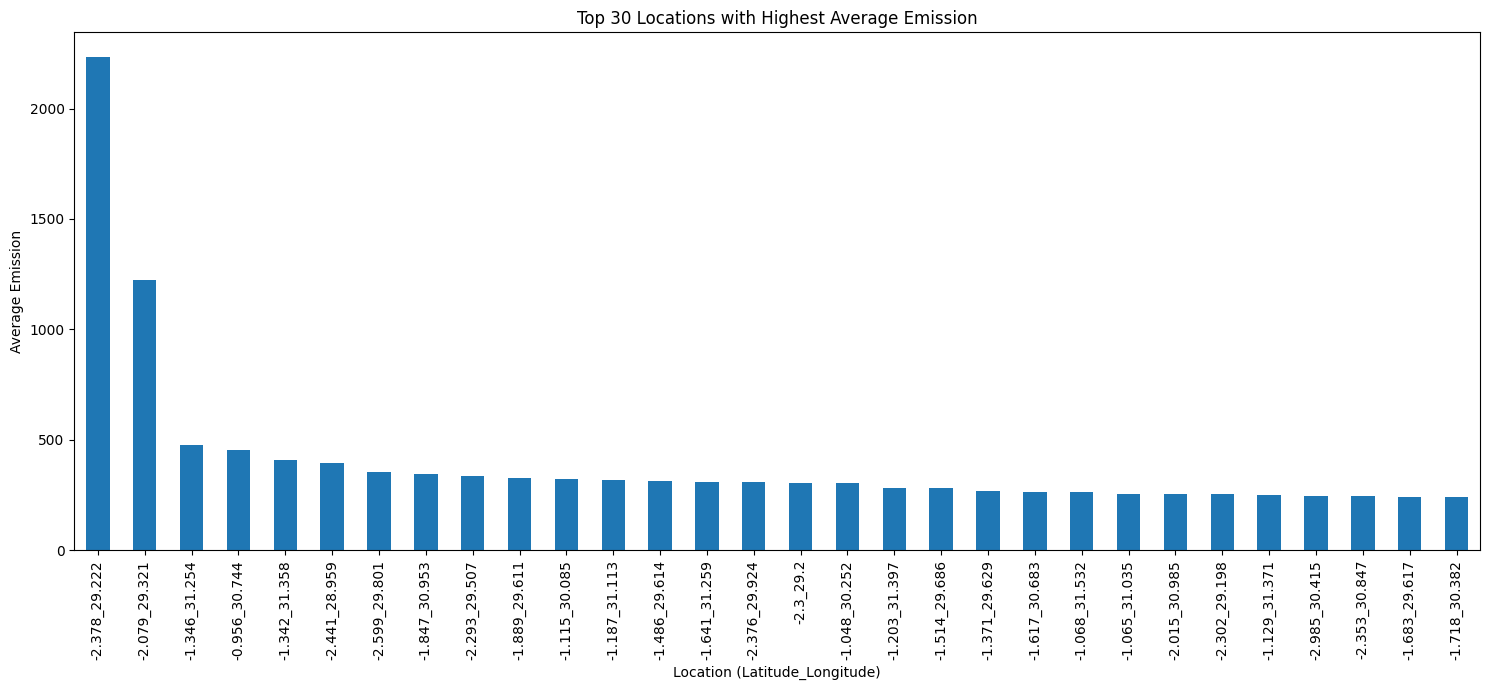

In [ ]:
# Group by 'location' and compute the average 'emission' for each location
avg_emission_by_location = train_imputed.groupby('location')['emission'].mean().sort_values(ascending=False)

# Plotting the average emission by location
plt.figure(figsize=(15, 7))
avg_emission_by_location.head(30).plot(kind='bar')  # Display top 30 locations for clarity
plt.title('Top 30 Locations with Highest Average Emission')
plt.xlabel('Location (Latitude_Longitude)')
plt.ylabel('Average Emission')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The AI comes to this conclusion:

- There's a noticeable variability in emissions across these top locations, with some having significantly higher average emissions than others.


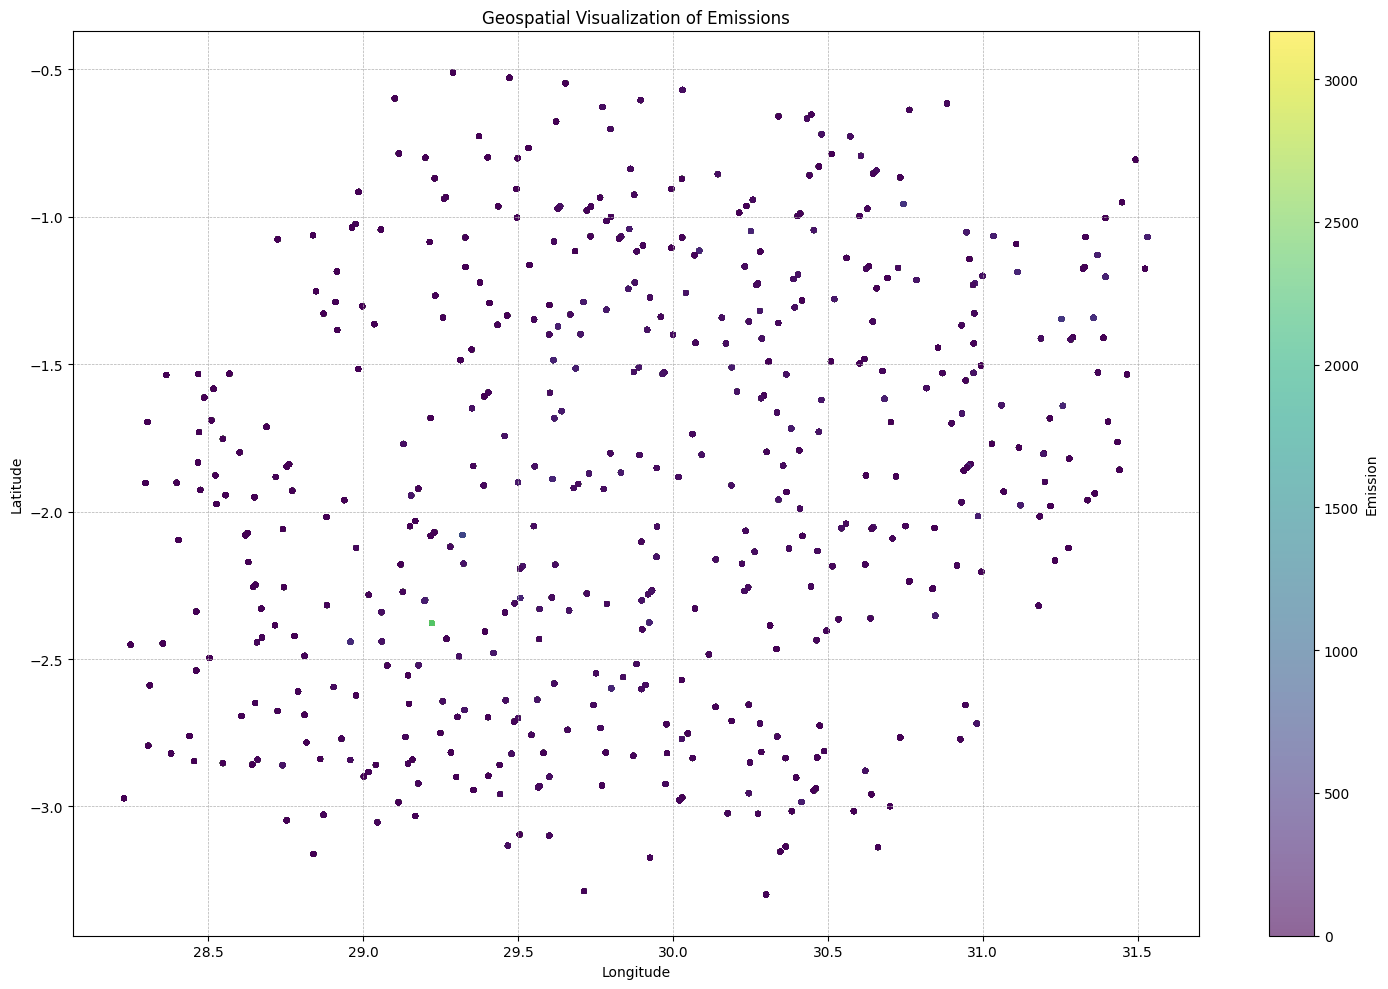

In [ ]:
# Extract latitude and longitude from the 'location' column for plotting
train_imputed['latitude_plot'] = train_imputed['location'].apply(lambda x: float(x.split('_')[0]))
train_imputed['longitude_plot'] = train_imputed['location'].apply(lambda x: float(x.split('_')[1]))

# Plotting
plt.figure(figsize=(15, 10))
scatter = plt.scatter(train_imputed['longitude_plot'],
                      train_imputed['latitude_plot'],
                      c=train_imputed['emission'],
                      cmap='viridis',
                      s=10,
                      alpha=0.6)

# Adding a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Emission')

# Setting the title and labels
plt.title('Geospatial Visualization of Emissions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


to my surprise, it utilizes a scatter plot for spatial analysis, which makes sense, but even so it's harder to observe with that that color scale, also, doesnt tell me anything about the location in Rwanda

I asked it to help me do a heatmap with the map of Rwanda, I have 0 experience with this

In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
heatmap_data = train_imputed[['latitude_plot', 'longitude_plot', 'emission']].groupby(['latitude_plot', 'longitude_plot']).mean().reset_index().values.tolist()


In [ ]:
rwanda_map = folium.Map(location=[-1.9403, 29.8739], zoom_start=8, tiles='cartodb positron')


In [ ]:
HeatMap(heatmap_data).add_to(rwanda_map)


In [ ]:
rwanda_map

It did it! It implemented it with no effort. Now lets proceed with step number 5, correlation analysis.



In [ ]:
#adding this manually since this columns where added un-necesarily by the AI
train_imputed = train_imputed.drop(columns = ['latitude_plot','longitude_plot'])

In [ ]:
# Compute correlation of each feature with the target variable 'emission'
correlation_with_target = train_imputed.corr()['emission'].sort_values(ascending=False)

# Drop the correlation of 'emission' with itself
correlation_with_target = correlation_with_target.drop('emission')

correlation_with_target


longitude                                                   0.102746
Cloud_surface_albedo                                        0.048290
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.033572
NitrogenDioxide_absorbing_aerosol_index                     0.023907
NitrogenDioxide_sensor_altitude                             0.019233
latitude                                                    0.017851
NitrogenDioxide_cloud_fraction                              0.015859
Ozone_O3_column_number_density                              0.013180
UvAerosolIndex_sensor_azimuth_angle                         0.009523
Ozone_sensor_azimuth_angle                                  0.009030
Cloud_sensor_azimuth_angle                                  0.008817
NitrogenDioxide_tropospheric_NO2_column_number_density      0.008561
week_no                                                     0.007086
UvAerosolIndex_absorbing_aerosol_index                      0.006306
SulphurDioxide_cloud_fraction     

Its coming up with this conclusions:

- Positive correlations imply that as the feature value increases, the emission tends to increase, while negative correlations suggest the opposite.
- The longitude and longitude_plot have the highest positive correlation with emissions. This suggests that emissions might vary systematically with the east-west direction in Rwanda.
- Many satellite-derived measurements, such as Cloud_surface_albedo and Formaldehyde_tropospheric_HCHO_column_number_density_amf, also show some correlation with emissions.
- On the negative side, features like CarbonMonoxide_CO_column_number_density and CarbonMonoxide_H2O_column_number_density have the strongest negative correlations with emissions.

Notice that it's only exploring simple linear correlation, **I'm going to ask it to explore autocorrelation in the time series**



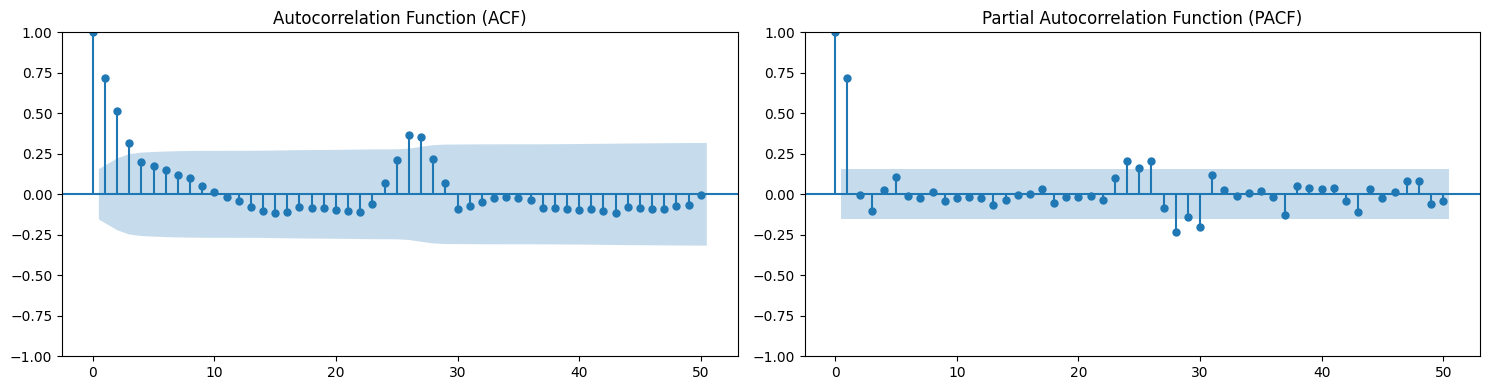

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extracting the emission values for autocorrelation analysis
emission_series = train_imputed.groupby(['year','week_no'])['emission'].mean()

# Plotting ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ACF plot
plot_acf(emission_series, ax=ax[0], lags=50)
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(emission_series, ax=ax[1], lags=50)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


Seems like now it understands there is autocorrelation in the data. He it is only exploring autocorrelation in the average emission by week. It's conclusions are:  

Here are the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for the emission series:

**ACF Plot:**

- The ACF shows significant autocorrelation at several lags, indicating a strong temporal structure in the data.
- The periodic peaks suggest a seasonality in the data, which is consistent with our previous observations from the time series plot.

**PACF Plot:**

- The PACF shows significant autocorrelation at the initial lags and then tapers off. This indicates that the emission value at any given time is influenced by its recent past values.
- The sharp cut-off after a few lags in the PACF suggests a potential autoregressive component in the data.
Understanding autocorrelat

Even with this we wont use any lag values of emission as predictors, since they tend to be problematic when writting code to do the actual prediction time (we would need to use loops likely)

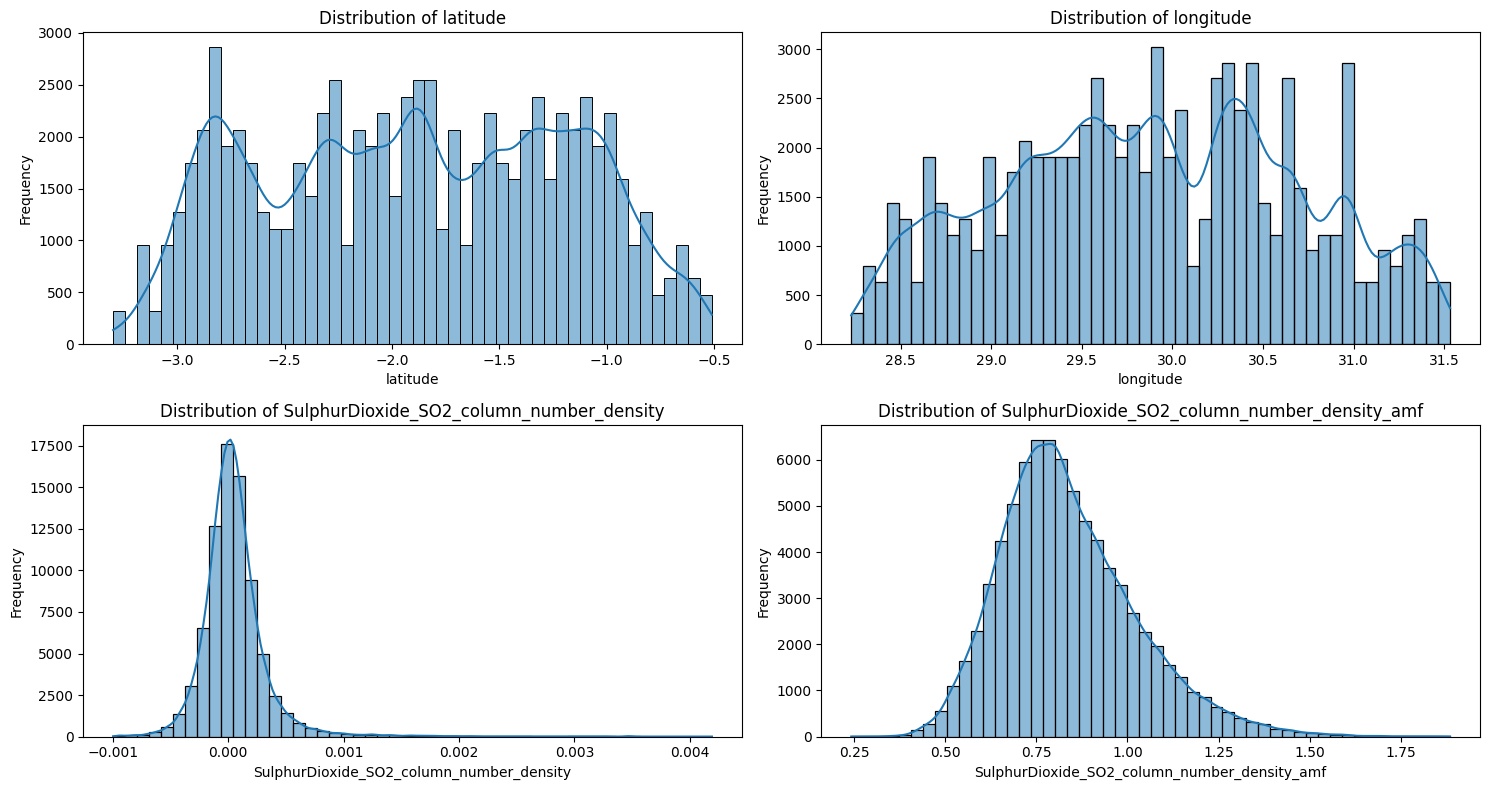

In [ ]:

# Plotting the distributions
non_feature_columns = ['location', 'year', 'emission','ID_LAT_LON_YEAR_WEEK','week_no'] ## !! had to modify this myself
existing_features = train_imputed.columns.drop(non_feature_columns)
features_to_plot = existing_features[:4]  # Selecting the first four features for simplicity


# Plotting the distributions
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_imputed[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()



In [ ]:
#train_imputed.to_csv('train_imputed.csv') # to give it to the AI again

It's still taking pretty long, we will skip this step in the AI and move forward with next steps: Outlier detection.

In [ ]:
# Detecting potential outliers per column per location using the IQR method
outliers_per_location = {}

for feature in features_to_plot:
    outliers_per_location[feature] = {}

    for location in train_imputed['location'].unique():
        subset = train_imputed[train_imputed['location'] == location]
        Q1 = subset[feature].quantile(0.25)
        Q3 = subset[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_condition = (subset[feature] < (Q1 - 1.5 * IQR)) | (subset[feature] > (Q3 + 1.5 * IQR))
        outliers_count = outlier_condition.sum()

        if outliers_count > 0:
            outliers_per_location[feature][location] = outliers_count

outliers_per_location



{'latitude': {},
 'longitude': {},
 'SulphurDioxide_SO2_column_number_density': {'-0.51_29.29': 6,
  '-0.528_29.472': 7,
  '-0.547_29.653': 5,
  '-0.569_30.031': 12,
  '-0.598_29.102': 7,
  '-0.604_29.896': 7,
  '-0.615_30.885': 13,
  '-0.627_29.773': 5,
  '-0.637_30.763': 3,
  '-0.653_30.447': 4,
  '-0.659_30.341': 2,
  '-0.667_30.433': 7,
  '-0.677_29.623': 4,
  '-0.702_29.798': 2,
  '-0.72_30.48': 12,
  '-0.726_29.374': 3,
  '-0.727_30.573': 15,
  '-0.766_29.534': 6,
  '-0.785_29.115': 7,
  '-0.787_30.513': 10,
  '-0.793_30.607': 13,
  '-0.798_29.402': 10,
  '-0.799_29.201': 10,
  '-0.801_29.499': 9,
  '-0.806_31.494': 9,
  '-0.829_30.471': 1,
  '-0.837_29.863': 6,
  '-0.843_30.657': 5,
  '-0.853_30.647': 7,
  '-0.855_30.145': 10,
  '-0.859_30.441': 7,
  '-0.866_30.734': 7,
  '-0.869_29.231': 9,
  '-0.871_30.029': 7,
  '-0.905_29.495': 14,
  '-0.905_29.995': 5,
  '-0.915_28.985': 9,
  '-0.925_29.875': 6,
  '-0.933_29.267': 10,
  '-0.935_29.765': 22,
  '-0.938_29.262': 12,
  '-0.942_

its only looking at outliers in 3 columns and comming up to a conclusion, we should proabbly tell it to review all columns and only present us information of columns and locations with more that ~12 outliers (3 months of outliers), but for simplicity, ill just let any potential outlier be since it shouldn't be that problematic in time series.

*Now it's suggesting moving forward with the steps:*



In [ ]:
#train_imputed.to_csv

## Feature Engeneering

We are only going to explore lag features for explanatory variables, we won't use lag features for emissions since they end up being too dominant in the tree model and complicated to use when predicting with the competition test dataset (I already tried)

In [ ]:
train_final = train_imputed.copy()
test_final = test_imputed.copy()

# 1. Lagged Features for Other Numerical Columns
#had to twick here to exclude the recently added columns

excluded_columns = ['latitude', 'longitude', 'location', 'week_no','month','year','emission']

numerical_columns = train_final.select_dtypes(include=['float64', 'int64']).columns

lag_columns = [col for col in numerical_columns if col not in excluded_columns]

for col in lag_columns:
    train_final[f'{col}_lag1'] = train_final.groupby('location')[col].rolling(window=2).mean().reset_index(0, drop=True)
    train_final[f'{col}_lag2'] = train_final.groupby('location')[col].rolling(window=2).mean().reset_index(0, drop=True)

for col in lag_columns:
    test_final[f'{col}_lag1'] = test_final.groupby('location')[col].rolling(window=2).mean().reset_index(0, drop=True)
    test_final[f'{col}_lag2'] = test_final.groupby('location')[col].rolling(window=2).mean().reset_index(0, drop=True)



In [ ]:
print(train_final.shape)
print(test_final.shape)

(79023, 196)
(24353, 195)



### Feature Selection

THe AI suggested that we do the current steps to find out what features would be relevant and it suggest a simple correlational analysis. Since I wanted to do something a bit more sophisticated I asked it to make suggestions for other methods, we end up choosing a Lasso regression for the job



In [ ]:
# One-hot encode the 'location' column
encoder = OneHotEncoder(drop='first', sparse=False) # drop='first' to avoid multicollinearity
encoded_location = encoder.fit_transform(train_final[['location']])
encoded_location_df = pd.DataFrame(encoded_location, columns=encoder.get_feature_names_out (['location']))

encoded_location_test = encoder.transform(test_final[['location']])
encoded_location_test_df = pd.DataFrame(encoded_location_test, columns=encoder.get_feature_names_out(['location']))


# Combine the one-hot encoded columns with the original dataframe
train_encoded = pd.concat([train_final.reset_index(drop=True), encoded_location_df], axis=1)
test_encoded = pd.concat([test_final.reset_index(drop=True), encoded_location_test_df], axis=1)


In [ ]:
print(train_encoded.shape)
print(test_encoded.shape)

(79023, 692)
(24353, 691)


In [ ]:


X = train_encoded.drop(columns=['emission', 'location', 'ID_LAT_LON_YEAR_WEEK'])
X = X.fillna(method = 'bfill')
y = train_encoded['emission']


In [ ]:

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

In [ ]:
# Train a Lasso regression model again
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:

# Extracting features with non-zero coefficients
selected_features = X.columns[lasso.coef_ != 0]
dropped_features = X.columns[lasso.coef_ == 0]



In [ ]:
print(selected_features)
#800 922 8228

Index(['latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'CarbonMonoxide_H2O_column_number_density',
       ...
       'location_-2.939_30.461', 'location_-2.955_30.245',
       'location_-2.959_30.641', 'location_-2.97_30.03',
       'location_-2.985_30.415', 'location_-3.016_30.384',
       'location_-3.016_30.584', 'location_-3.095_29.505',
       'location_-3.133_29.467', 'location_-3.136_30.364'],
      dtype='object', length=301)


## Training a Random Forest Model

Since we have several time series in the data set (1 per location) and many features to this time series, I'll opt for the a model that can handle all the series at the same time, otherwise, we would need to train a Time Series model per location iteratively

In [ ]:

# Initialize and train the model
rf = RandomForestRegressor(n_estimators=50, random_state=123)
rf.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = rf.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Test RMSE: 18.38227312059736


In [ ]:
test_encoded['emission_pred'] = rf.predict(test_encoded[selected_features].fillna(method='bfill'))
train_encoded['emission_pred']  = rf.predict(train_encoded[selected_features].fillna(method='bfill'))


In [ ]:
all_data = pd.concat([test_encoded, train_encoded], axis=0).reset_index(drop=True)

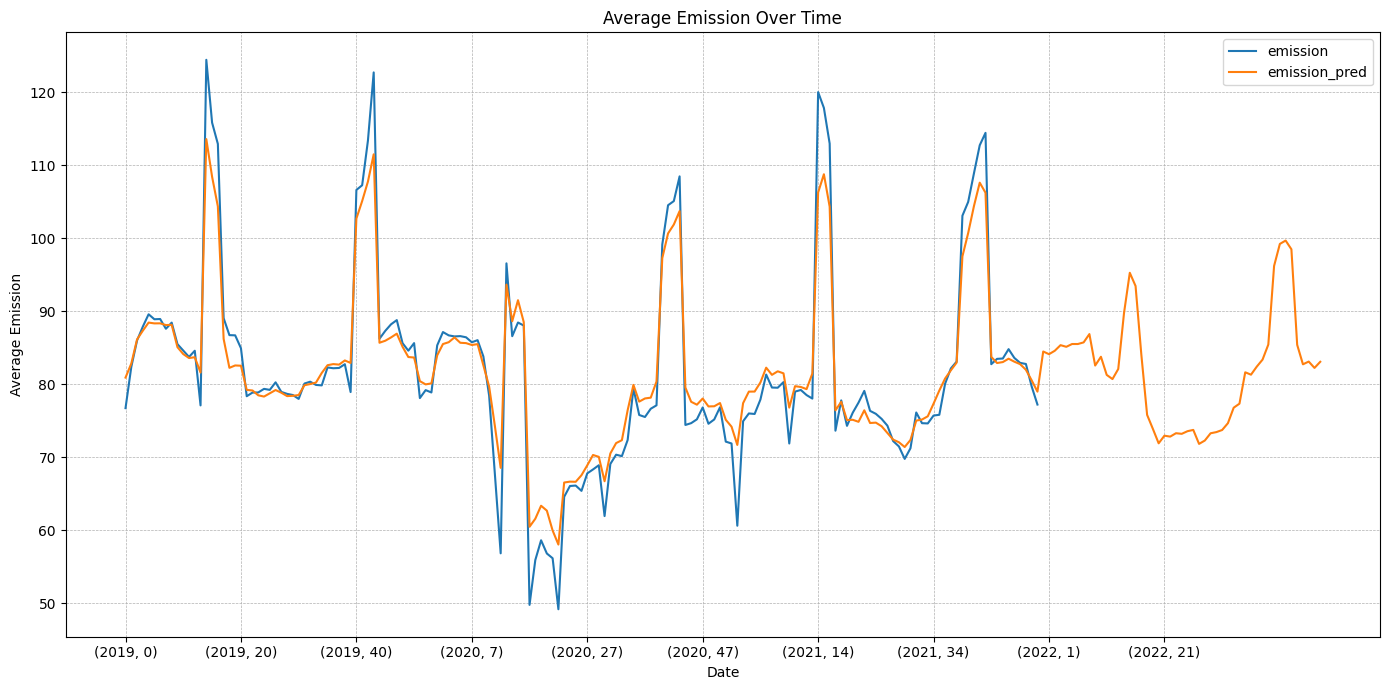

In [ ]:
viz_group = all_data.groupby(['year','week_no']).mean()[['emission','emission_pred']]

# Plotting the average emission over time
plt.figure(figsize=(14, 7))
viz_group.emission.plot()

viz_group.emission_pred.plot()

plt.title('Average Emission Over Time')
plt.xlabel('Date')
plt.ylabel('Average Emission')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

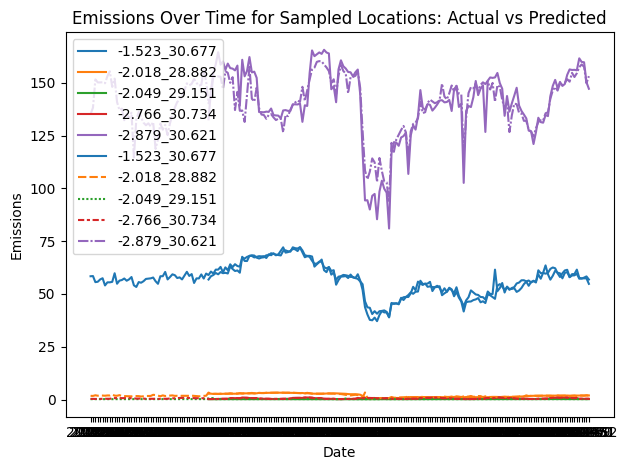

<Figure size 1400x700 with 0 Axes>

In [ ]:
sampled_locations = all_data['location'].sample(5).unique()
sampled_data = all_data[all_data['location'].isin(sampled_locations)]


sampled_data['date'] = sampled_data['year'].astype(str) + "-" + sampled_data['week_no'].astype(str)
# Plotting the actual emissions for the sampled locations
sns.lineplot(data=sampled_data, x='date', y='emission', hue='location', style='location', palette='tab10', dashes=False)

# Plotting the predicted emissions for the test period of the sampled locations
sns.lineplot(data=sampled_data, x='date', y='emission_pred', hue='location', style='location', palette='tab10', dashes=True)


plt.title('Emissions Over Time for Sampled Locations: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()

plt.tight_layout()
plt.figure(figsize=(14, 7))

plt.show()

CLearly not a great prediction..., its_probably overfitting too much on the lag emission features..?

In [ ]:
importances = rf.feature_importances_

In [ ]:

sorted_idx = importances.argsort()


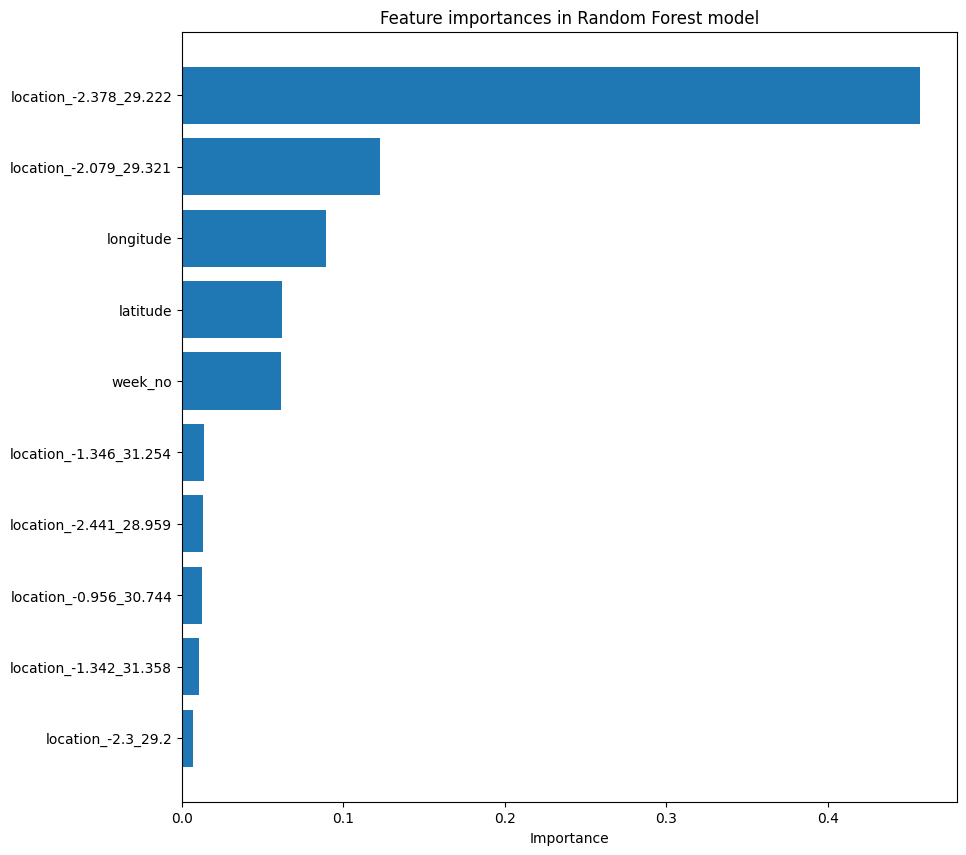

In [ ]:


plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx[-10:])), importances[sorted_idx[-10:]], align='center')
plt.yticks(range(len(sorted_idx[-10:])), selected_features[sorted_idx[-10:]])
plt.xlabel('Importance')
plt.title('Feature importances in Random Forest model')
plt.show()

In [ ]:
submission_rf = test_encoded[['ID_LAT_LON_YEAR_WEEK','emission_pred']].rename(columns = {'emission_pred' : 'emission'})

In [ ]:

submission_file_name = "submission_rf.csv"
submission_rf.to_csv(submission_file_name, index=False)

!kaggle competitions submit -c playground-series-s3e20 -f submission_rf.csv -m "RFV1 submission"



100% 989k/989k [00:01<00:00, 892kB/s]
Successfully submitted to Predict CO2 Emissions in Rwanda

In [ ]:
'''
import json

# Download the leaderboard
!kaggle competitions leaderboard playground-series-s3e20 --download -p /content/

# Extract submission details
with open("/content/playground-series-s3e20-publicleaderboard.json", 'r') as f:
    leaderboard_data = json.load(f)

# Print out submission score and position (assuming your username is 'my_username')
for entry in leaderboard_data:
    if entry['teamName'] == 'Mario_DS':
        print(f"Submission Score: {entry['score']}")
        print(f"Position: {entry['rank']}")
        '''

'\nimport json\n\n# Download the leaderboard\n!kaggle competitions leaderboard playground-series-s3e20 --download -p /content/\n\n# Extract submission details\nwith open("/content/playground-series-s3e20-publicleaderboard.json", \'r\') as f:\n    leaderboard_data = json.load(f)\n\n# Print out submission score and position (assuming your username is \'my_username\')\nfor entry in leaderboard_data:\n    if entry[\'teamName\'] == \'Mario_DS\':\n        print(f"Submission Score: {entry[\'score\']}")\n        print(f"Position: {entry[\'rank\']}")\n        '

## Training XGBoost Model

This model is a more powerfull version of Random Forest, using this model was also suggested by the AI, I will see if I can get better results with this model, but I expect that this model is more likely to overfit.

We will try first with a set of standard parameters and see the results

In [ ]:
# Initialize XGBoost regressor
model = xgb.XGBRegressor(
    objective ='reg:squarederror',  # Regression objective
    colsample_bytree = 0.3,         # Fraction of features per tree
    learning_rate = 0.1,            # Step size shrinkage
    max_depth = 5,                  # Maximum depth of a tree
    alpha = 10,                     # L1 regularization term on weights
    n_estimators = 100,              # Number of boosting rounds
     tree_method='gpu_hist'
)



In [ ]:

# Train the model
model.fit(X_train[selected_features], y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [ ]:
#previous model mse was 18
y_pred_val = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred_val)
print(f"Validation MSE: {mse}")

Validation MSE: 2262.063359174155


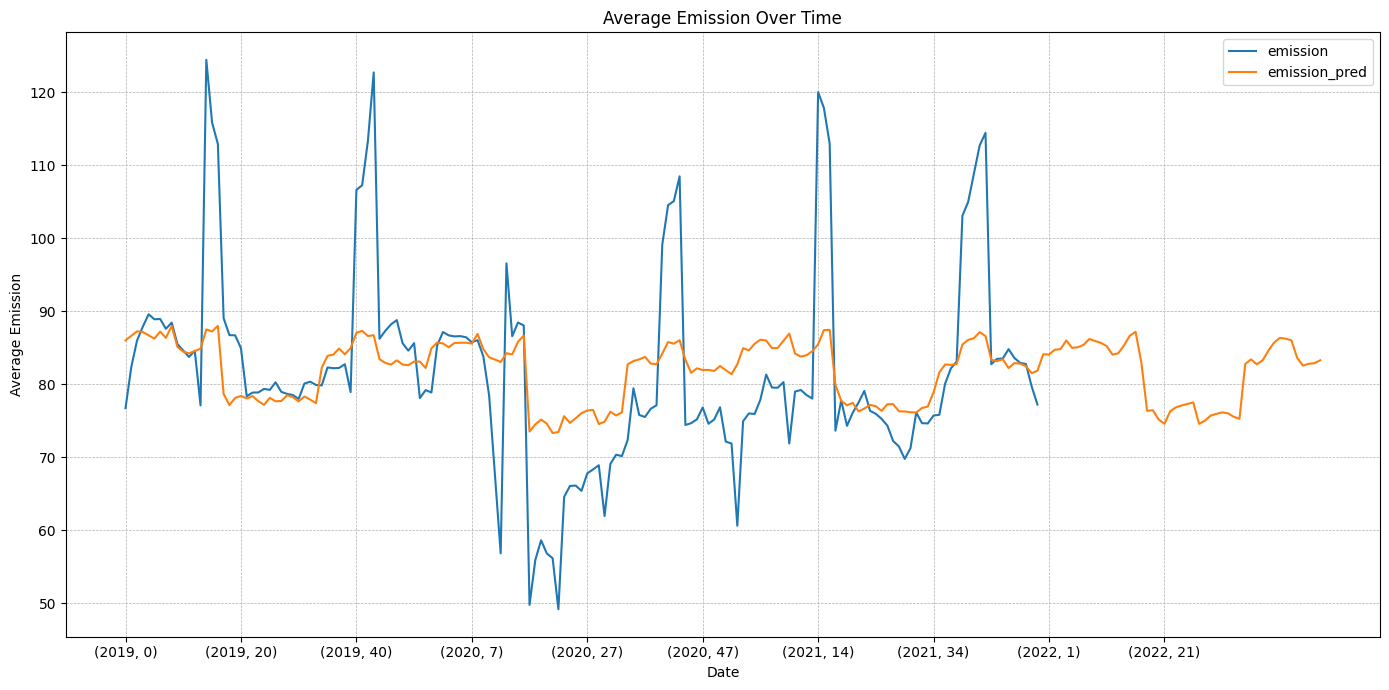

In [ ]:
test_encoded['emission_pred'] = model.predict(test_encoded[selected_features].fillna(method='bfill'))
train_encoded['emission_pred']  = model.predict(train_encoded[selected_features].fillna(method='bfill'))

all_data = pd.concat([test_encoded, train_encoded], axis=0).reset_index(drop=True)

viz_group = all_data.groupby(['year','week_no']).mean()[['emission','emission_pred']]

# Plotting the average emission over time
plt.figure(figsize=(14, 7))
viz_group.emission.plot()

viz_group.emission_pred.plot()

plt.title('Average Emission Over Time')
plt.xlabel('Date')
plt.ylabel('Average Emission')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**The predictions don't look all that great and the MSE is huge, it's ~2.4k which is huge compare to the RF MSE that was ~18, it seems like it's not able to capture all the patters in the data well**

We will try to optimize the paramenters using a randomized grid search and see if we get better results, this method might over fit though, so we will keep the regularization terms fairly high (alpha = 1, and lambda = 10)

In [ ]:
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'n_estimators': np.arange(50, 1000, 50),
    'max_depth': np.arange(3, 10, 1),
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'colsample_bylevel': np.linspace(0.5, 1, 6),
    'min_child_weight': np.arange(1, 10, 1),
    'gamma': np.linspace(0, 0.5, 6),
    'alpha': [ 1, 1.25 , 1.5],
    'lambda': [10 , 15, 20]
}

model_2 = xgb.XGBRegressor(objective='reg:squarederror', silent=True, nthread=1, tree_method='gpu_hist')

random_search = RandomizedSearchCV(
    model_2,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled (increase for more exhaustive search)
    scoring='neg_mean_squared_error',  # You can use other metrics as well
    cv=5,
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

In [ ]:
random_search.fit(X_train[selected_features], y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[17:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'lambda': [10, 15, 20],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          0.5],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 950, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.1, 'lambda': 15, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'alpha': 1}


In [ ]:
y_pred_val = random_search.best_estimator_.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred_val)
print(f"Validation MSE with Best Model: {mse}")

Validation MSE with Best Model: 300.8219011060875


The MSE got significantly better, but it's still pretty high, suggesting either overfitting or that this is it's limit, lets see how it's predicting and submit to kaggle to get our MSE score

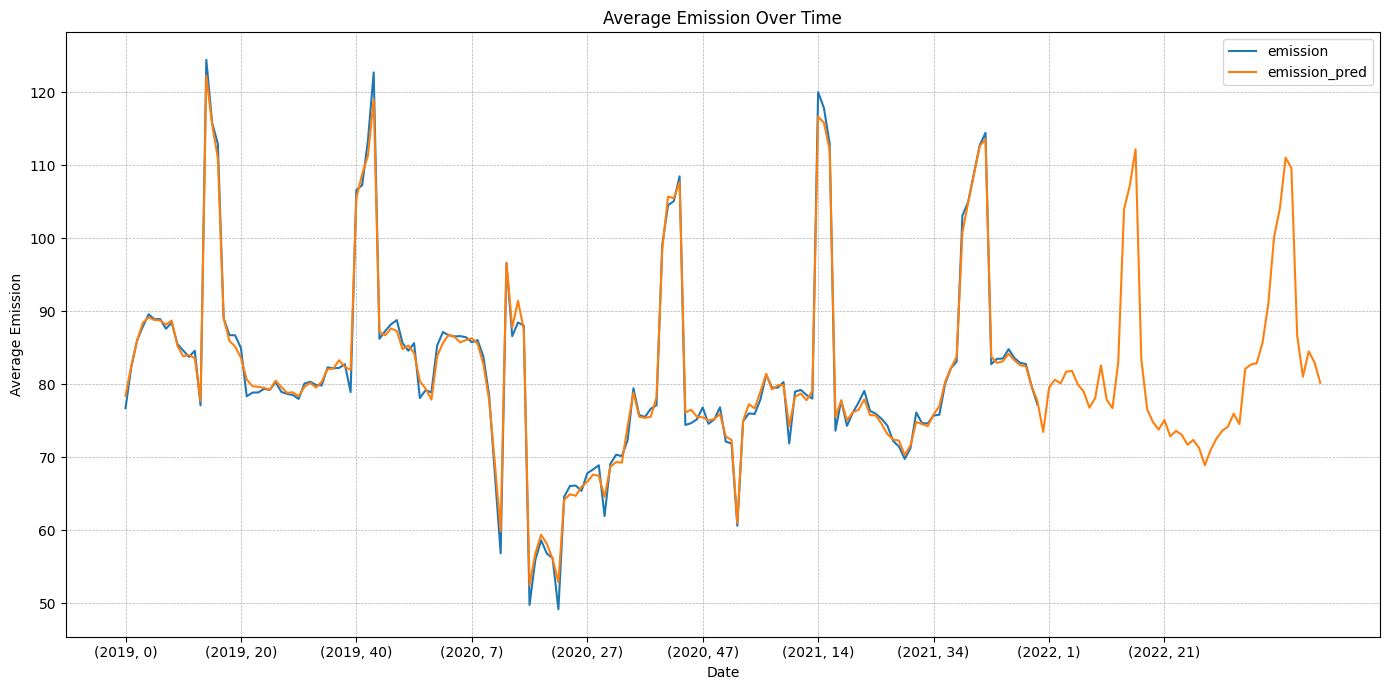

In [ ]:

test_encoded['emission_pred'] = random_search.best_estimator_.predict(test_encoded[selected_features].fillna(method='bfill'))
train_encoded['emission_pred']  = random_search.best_estimator_.predict(train_encoded[selected_features].fillna(method='bfill'))

all_data = pd.concat([test_encoded, train_encoded], axis=0).reset_index(drop=True)

viz_group = all_data.groupby(['year','week_no']).mean()[['emission','emission_pred']]

# Plotting the average emission over time
plt.figure(figsize=(14, 7))
viz_group.emission.plot()

viz_group.emission_pred.plot()

plt.title('Average Emission Over Time')
plt.xlabel('Date')
plt.ylabel('Average Emission')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
submission_xgb = test_encoded[['ID_LAT_LON_YEAR_WEEK','emission_pred']].rename(columns = {'emission_pred' : 'emission'})

In [ ]:

submission_file_name = "submission_xgb.csv"
submission_xgb.to_csv(submission_file_name, index=False)

!kaggle competitions submit -c playground-series-s3e20 -f submission_xgb.csv -m "XGBV1 model"




100% 826k/826k [00:00<00:00, 890kB/s]
Successfully submitted to Predict CO2 Emissions in Rwanda

The resulted MSe of the XGB model submission was a bit worse as expected, it was 24.68, compared to the 23.78 we got with the Random Forest Model. We will try another more complex model and see what happens



## Training a Long-Short Term Model (Deep Learning)

We will now try to implement a more sophisticated model that can take into account the temporal structure of the data natively, this perhaps will allow for better predictions.

We are starting again from the train imputed dataset (train dataset, without high null values columns and with forward fill imputed values in the missing remaining values)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#test_imputed['emissions'] = np.random.uniform(10, 50, test_imputed.shape[0])


In [ ]:
# Temporarily adding an emission in the test dataset so that we can easily scale it using MinMaxScaler()
test_imputed['emission'] = np.random.randint(0, 100, test_imputed.shape[0])


In [ ]:

cols_to_drop_train = ['ID_LAT_LON_YEAR_WEEK', 'location']
cols_to_drop_test = ['ID_LAT_LON_YEAR_WEEK','location']
train_for_scaling = train_imputed.drop(columns=cols_to_drop_train)
test_for_scaling = test_imputed.drop(columns=cols_to_drop_test)


In [ ]:
# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
train_normalized_values = scaler.fit_transform(train_for_scaling)
test_normalized_values = scaler.transform(test_for_scaling)

# Convert back to DataFrames
train_normalized = pd.DataFrame(train_normalized_values, columns=train_for_scaling.columns)
test_normalized = pd.DataFrame(test_normalized_values, columns=test_for_scaling.columns)

# Add back the 'emission', 'ID_LAT_LON_YEAR_WEEK', and 'location' columns to the normalized data
#train_normalized['emission'] = train_imputed['emission']
train_normalized['ID_LAT_LON_YEAR_WEEK'] = train_imputed['ID_LAT_LON_YEAR_WEEK']
train_normalized['location'] = train_imputed['location']

test_normalized['ID_LAT_LON_YEAR_WEEK'] = test_imputed['ID_LAT_LON_YEAR_WEEK']
test_normalized['location'] = test_imputed['location']

# Display the first few rows of the normalized train dataset

In [ ]:
# Adding the sequence length last values of the train set into the test dataset so that we can predict with the first value
sequence_length = 12
test_normalized = pd.concat([train_normalized.tail(sequence_length),test_normalized],axis = 0 ).drop(columns = ['emission'])

In [ ]:
# Creating a function to transform the data into the required LSTM sequences per observation
def create_train_val_sequences(data, sequence_length, val_weeks=12):
    X_train, y_train, train_metadata = [], [], []
    X_val, y_val, val_metadata = [], [], []

    # Splitting data into training and validation based on the specified validation weeks
    train_data = data.iloc[:-val_weeks]
    val_data = data.iloc[-(val_weeks + sequence_length):]  # Including additional weeks for sequence creation

    # Creating sequences for training data
    for i in range(len(train_data) - sequence_length):
        X_train.append(train_data.iloc[i:i+sequence_length].drop(columns=['ID_LAT_LON_YEAR_WEEK', 'location','emission']).values)
        y_train.append(train_data.iloc[i+sequence_length]['emission'])
        train_metadata.append(train_data.iloc[i+sequence_length][['year', 'week_no', 'latitude', 'longitude']])

    # Creating sequences for validation data
    for i in range(len(val_data) - sequence_length):
        X_val.append(val_data.iloc[i:i+sequence_length].drop(columns=['ID_LAT_LON_YEAR_WEEK', 'location', 'emission']).values)
        y_val.append(val_data.iloc[i+sequence_length]['emission'])
        val_metadata.append(val_data.iloc[i+sequence_length][['year', 'week_no', 'latitude', 'longitude']])

    return (np.array(X_train), np.array(y_train), pd.DataFrame(train_metadata),
            np.array(X_val), np.array(y_val), pd.DataFrame(val_metadata))


#Creating a sequence per location

locations = train_normalized['location'].unique()
sequence_length = 12

X_train, y_train, train_metadata = [], [], []
X_val, y_val, val_metadata = [], [], []

for loc in locations:
    loc_data = train_normalized[train_normalized['location'] == loc].sort_values(by=['year', 'week_no'])

    X_loc_train, y_loc_train, metadata_loc_train, X_loc_val, y_loc_val, metadata_loc_val = create_train_val_sequences(loc_data, sequence_length, val_weeks=12)

    # Append sequences and metadata to the respective lists
    X_train.extend(X_loc_train)
    y_train.extend(y_loc_train)
    train_metadata.append(metadata_loc_train)

    X_val.extend(X_loc_val)
    y_val.extend(y_loc_val)
    val_metadata.append(metadata_loc_val)

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

# Concatenate metadata DataFrames.
# We save the metadata to later be able to easily join predictions to train and test datasets by location and week number
train_metadata = pd.concat(train_metadata, ignore_index=True)
val_metadata = pd.concat(val_metadata, ignore_index=True)



In [ ]:
#Same here we need the test dataset in the same format. It needs some tweak compared to train dataset
# This dataset is missing an emission column due to the competition format
# We are not splitting it into two like the train dataset

def create_test_sequences(data, sequence_length):
    X_test, test_metadata = [], []

    # Creating sequences for test data
    for i in range(len(data) - sequence_length):
        X_test.append(data.iloc[i:i+sequence_length].drop(columns=['ID_LAT_LON_YEAR_WEEK', 'location']).values)
        test_metadata.append(data.iloc[i+sequence_length][['year', 'week_no', 'latitude', 'longitude']])

    return np.array(X_test), pd.DataFrame(test_metadata)

X_test, test_metadata = [], []

locations = test_normalized['location'].unique()

for loc in locations:
    loc_data = test_normalized[test_normalized['location'] == loc].sort_values(by=['year', 'week_no'])

    X_loc_test, metadata_loc_test = create_test_sequences(loc_data, sequence_length)

    # Append sequences and metadata to the respective lists
    X_test.extend(X_loc_test)
    test_metadata.append(metadata_loc_test)

# Convert list to numpy array
X_test = np.array(X_test)

# Concatenate metadata DataFrame
# We save the metadata to later be able to easily join predictions to train and test datasets by location and week number
test_metadata = pd.concat(test_metadata, ignore_index=True)


In [ ]:
#naking sure we have the required shapes: (observations, lookback steps, features)
X_test.shape, X_train.shape

((18401, 12, 67), (67095, 12, 67))

In [ ]:
# Define the model
model = Sequential()

# Add LSTM layer with 50 units and 'relu' activation function
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add Dense layer with 1 unit for regression output
model.add(Dense(1))

# Compile the model using MSE as the loss function and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                23600     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23651 (92.39 KB)
Trainable params: 23651 (92.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Number of iterations over the entire dataset
    batch_size=32,  # Number of samples per gradient update
    verbose=1  # Verbosity mode: 1 = progress bar, 0 = silent, 2 = one line per epoch
)


Epoch 1/100
1049/1049 [==============================] - 20s 17ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/100
1049/1049 [==============================] - 15s 15ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/100
1049/1049 [==============================] - 16s 15ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/100
1049/1049 [==============================]

In [ ]:
# model.save('lstm_emissions_model_v2.h5')


In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)


576/576 [==============================] - 2s 3ms/step


In [ ]:
#getting the scaling parameters to observe Loss in de-normalize amounts
emission_min = scaler.data_min_[train_for_scaling.columns.get_loc("emission")]
emission_max = scaler.data_max_[train_for_scaling.columns.get_loc("emission")]
(emission_max - emission_min) + emission_min

In [ ]:
# Evaluate model on training data
train_loss = model.evaluate(X_train, y_train)

# Evaluate model on validation data
val_loss = model.evaluate(X_val, y_val)

print(f"Training MSE (Loss): {train_loss * (emission_max - emission_min) + emission_min }")
print(f"Validation MSE (Loss): {val_loss * (emission_max - emission_min) + emission_min }")

print(f"Training MSE (Loss): {train_loss * (emission_max - emission_min) + emission_min }")
print(f"Validation MSE (Loss): {val_loss * (emission_max - emission_min) + emission_min }")



187/187 [==============================] - 1s 3ms/step - loss: 0.0015
Training MSE (Loss): 1.8397677388684823
Validation MSE (Loss): 4.88472475597728


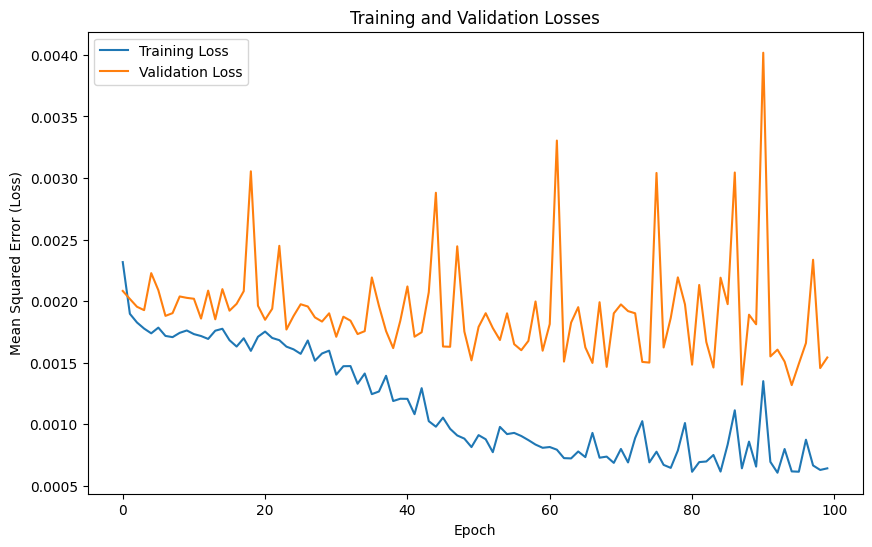

In [ ]:
# Visualizing Training and Validation Loss
# Ideally we want to see validation loss stabilize elbow fashion

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.show()

- Not Great, the algorithm seems to be improving the training fit but not really having improvements in the validation, meaning that we will likely see very bad results

In [ ]:

# Convert predictions to DataFrames
train_predictions_df = pd.DataFrame(train_predictions, columns=['predicted_emission'])
val_predictions_df = pd.DataFrame(val_predictions, columns=['predicted_emission'])
test_predictions_df = pd.DataFrame(test_predictions, columns=['predicted_emission'])

# Joining predictions with train_metadata and val_metadata
train_results = pd.concat([train_metadata.reset_index(drop=True), train_predictions_df], axis=1)
val_results = pd.concat([val_metadata.reset_index(drop=True), val_predictions_df], axis=1)
test_results = pd.concat([test_metadata.reset_index(drop=True), test_predictions_df], axis=1)





<Axes: xlabel='year,week_no'>

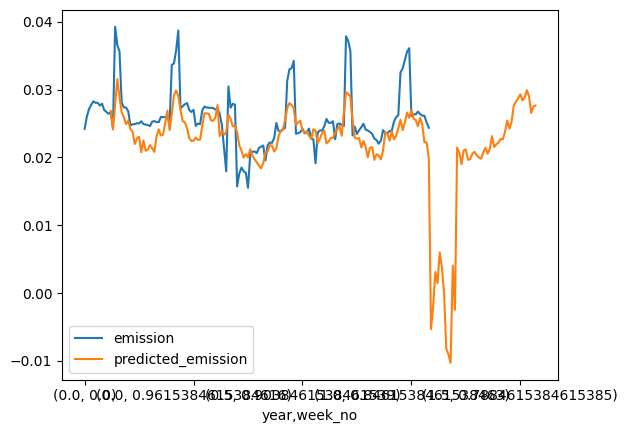

In [ ]:
#Observing how the algorithm performs in the average and how the predictions look like
train_joined = pd.merge(
    pd.concat([train_normalized,test_normalized],axis = 0),
    pd.concat([train_results,val_results,test_results],axis = 0),
    on=['year', 'week_no', 'latitude', 'longitude'], how='left')

train_joined.groupby(['year','week_no']).mean()[['emission','predicted_emission']].plot(kind='line')

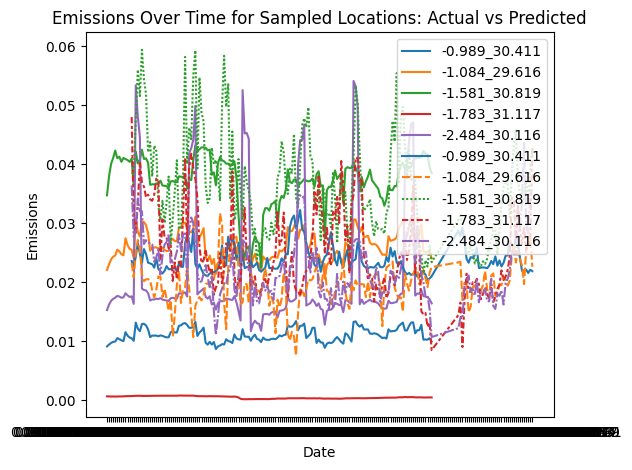

<Figure size 1400x1400 with 0 Axes>

In [ ]:
sampled_locations = train_joined['location'].sample(5).unique()
sampled_data = train_joined[train_joined['location'].isin(sampled_locations)]


sampled_data['date'] = sampled_data['year'].astype(str) + "-" + sampled_data['week_no'].astype(str)
# Plotting the actual emissions for the sampled locations
sns.lineplot(data=sampled_data, x='date', y='emission', hue='location', style='location', palette='tab10', dashes=False)

# Plotting the predicted emissions for the test period of the sampled locations
sns.lineplot(data=sampled_data, x='date', y='predicted_emission', hue='location', style='location', palette='tab10', dashes=True)


plt.title('Emissions Over Time for Sampled Locations: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()

plt.tight_layout()
plt.figure(figsize=(14, 14))

plt.show()

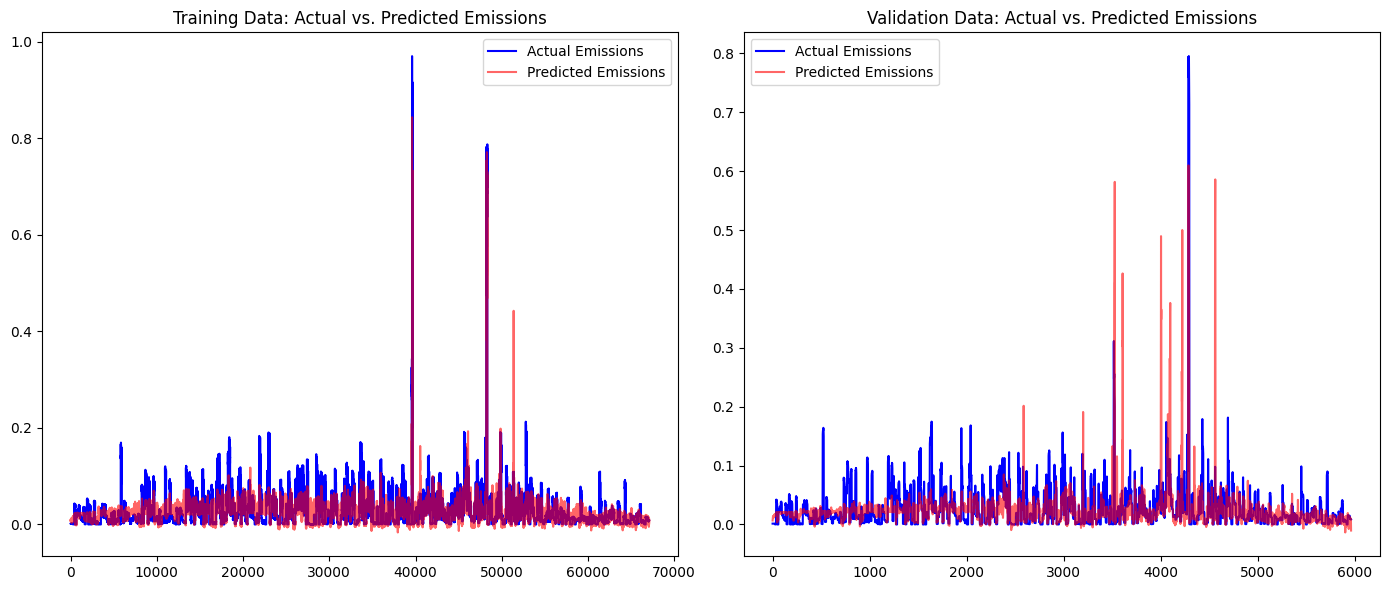

In [ ]:

# Extract the corresponding actual values for emissions (since our sequences are used to predict the next value)
y_train_actual = y_train
y_val_actual = y_val

# Plot actual vs. predicted emissions for training data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Emissions', color='blue')
plt.plot(train_predictions, label='Predicted Emissions', color='red', alpha=0.6)
plt.title('Training Data: Actual vs. Predicted Emissions')
plt.legend()

# Plot actual vs. predicted emissions for validation data
plt.subplot(1, 2, 2)
plt.plot(y_val_actual, label='Actual Emissions', color='blue')
plt.plot(val_predictions, label='Predicted Emissions', color='red', alpha=0.6)
plt.title('Validation Data: Actual vs. Predicted Emissions')
plt.legend()

plt.tight_layout()
plt.show()



Seems like the algorithm is performing really bad. In my opinion it could be a few hypothesis:

- Lack of lagging emission values in the training dataset
- No time invariant location features have been added
- The model is learning the outlier covid performance where emissions are dropping significantly
- Perhaps a bug in the model I'm not aware of off

In [ ]:
# Extract the original columns for denormalization
cols_for_denormalization = train_for_scaling.columns#.append(pd.Index(['predicted_emission']))
train_final_results = train_joined.copy()


In [ ]:
# Denormalize train_joined and val_joined
train_final_results[cols_for_denormalization] = scaler.inverse_transform(train_joined[cols_for_denormalization])
train_final_results['predicted_emission'] = train_final_results['predicted_emission'] * (emission_max - emission_min) + emission_min

<Axes: xlabel='year,week_no'>

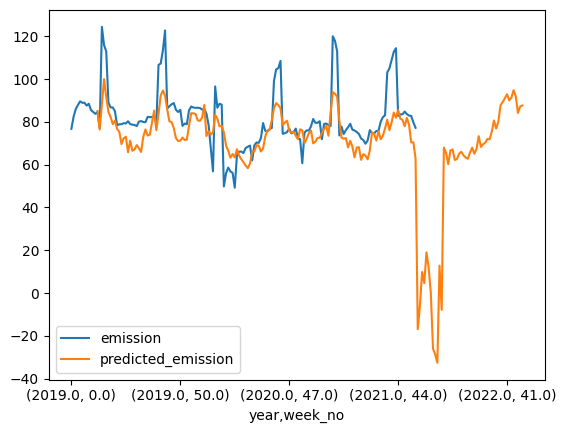

In [ ]:
#Vizualizing results in normal scale
train_final_results.groupby(['year','week_no']).mean()[['emission','predicted_emission']].plot(kind='line')

### Re-training the LSTM
-  To keep it simple, we are going to re-train the model but this time we will add an emission lag1 and lag2 columns

In [104]:
train_normalized_v2 = train_normalized.copy()


In [105]:
train_normalized_v2['emission_lag1'] = train_normalized_v2.groupby('location')['emission'].shift(1)
train_normalized_v2['emission_lag2'] = train_normalized_v2.groupby('location')['emission'].shift(2) # added this manually

#drop rows with na introduced due to lag
train_normalized_v2 = train_normalized_v2.dropna(axis = 0)

In [106]:
locations = train_normalized_v2['location'].unique()
sequence_length = 12

X_train, y_train, train_metadata = [], [], []
X_val, y_val, val_metadata = [], [], []

for loc in locations:
    loc_data = train_normalized_v2[train_normalized_v2['location'] == loc].sort_values(by=['year', 'week_no'])

    X_loc_train, y_loc_train, metadata_loc_train, X_loc_val, y_loc_val, metadata_loc_val = create_train_val_sequences(loc_data, sequence_length, val_weeks=12)

    # Append sequences and metadata to the respective lists
    X_train.extend(X_loc_train)
    y_train.extend(y_loc_train)
    train_metadata.append(metadata_loc_train)

    X_val.extend(X_loc_val)
    y_val.extend(y_loc_val)
    val_metadata.append(metadata_loc_val)

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

# Concatenate metadata DataFrames.
# We save the metadata to later be able to easily join predictions to train and test datasets by location and week number
train_metadata = pd.concat(train_metadata, ignore_index=True)
val_metadata = pd.concat(val_metadata, ignore_index=True)

In [107]:
# Define the model
model_v2 = Sequential()

# Add LSTM layer with 50 units and 'relu' activation function
model_v2.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add Dropout layer to prevent overfitting
model_v2.add(Dropout(0.2))

# Add Dense layer with 1 unit for regression output
model_v2.add(Dense(1))

# Compile the model using MSE as the loss function and Adam optimizer
model_v2.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model_v2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                24000     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 24051 (93.95 KB)
Trainable params: 24051 (93.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [108]:
# Train the model
history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Number of iterations over the entire dataset
    batch_size=32,  # Number of samples per gradient update
    verbose=1  # Verbosity mode: 1 = progress bar, 0 = silent, 2 = one line per epoch
)


Epoch 1/100
2066/2066 [==============================] - 35s 16ms/step - loss: 0.0017 - val_loss: 2.6792e-04
Epoch 2/100
2066/2066 [==============================] - 30s 14ms/step - loss: 3.3654e-04 - val_loss: 1.4703e-04
Epoch 3/100
2066/2066 [==============================] - 30s 14ms/step - loss: 2.6901e-04 - val_loss: 1.5885e-04
Epoch 4/100
2066/2066 [==============================] - 30s 15ms/step - loss: 2.3357e-04 - val_loss: 1.2654e-04
Epoch 5/100
2066/2066 [==============================] - 31s 15ms/step - loss: 2.3890e-04 - val_loss: 1.4329e-04
Epoch 6/100
2066/2066 [==============================] - 32s 16ms/step - loss: 2.0112e-04 - val_loss: 1.5890e-04
Epoch 7/100
2066/2066 [==============================] - 30s 14ms/step - loss: 2.0557e-04 - val_loss: 1.3163e-04
Epoch 8/100
2066/2066 [==============================] - 29s 14ms/step - loss: 2.1292e-04 - val_loss: 1.0805e-04
Epoch 9/100
2066/2066 [==============================] - 29s 14ms/step - loss: 1.9795e-04 - val_loss

In [109]:
# Make predictions
train_predictions = model_v2.predict(X_train)
val_predictions = model_v2.predict(X_val)

# Evaluate model on training data
train_loss = model_v2.evaluate(X_train, y_train)

# Evaluate model on validation data
val_loss = model_v2.evaluate(X_val, y_val)

print(f"Training MSE (Loss): {train_loss * (emission_max - emission_min) + emission_min }")
print(f"Validation MSE (Loss): {val_loss * (emission_max - emission_min) + emission_min }")

print(f"Training MSE (Loss): {train_loss * (emission_max - emission_min) + emission_min }")
print(f"Validation MSE (Loss): {val_loss * (emission_max - emission_min) + emission_min }")

187/187 [==============================] - 1s 3ms/step - loss: 6.9313e-05
Training MSE (Loss): 0.10883940458012512
Validation MSE (Loss): 0.21956724565505284
Training MSE (Loss): 0.10883940458012512
Validation MSE (Loss): 0.21956724565505284


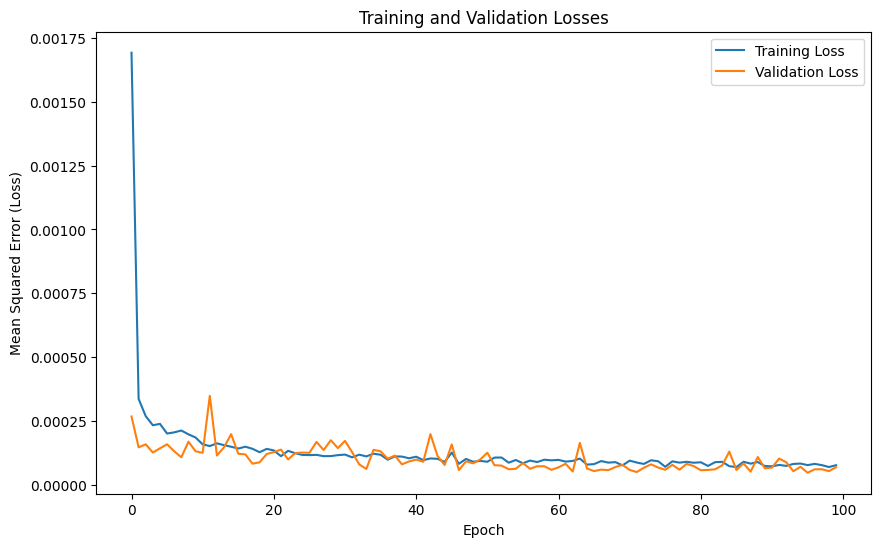

In [111]:
# Visualizing Training and Validation Loss
# Ideally we want to see validation loss stabilize elbow fashion

plt.figure(figsize=(10, 6))
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.show()

In [112]:
# Convert predictions to DataFrames
train_predictions_df = pd.DataFrame(train_predictions, columns=['predicted_emission'])
val_predictions_df = pd.DataFrame(val_predictions, columns=['predicted_emission'])

# Joining predictions with train_metadata and val_metadata
train_results = pd.concat([train_metadata.reset_index(drop=True), train_predictions_df], axis=1)
val_results = pd.concat([val_metadata.reset_index(drop=True), val_predictions_df], axis=1)
test_results = pd.concat([test_metadata.reset_index(drop=True), test_predictions_df], axis=1)


In [113]:
#Observing how the algorithm performs in the average and how the predictions look like
train_joined_v2 = pd.merge(
    train_normalized_v2,
    pd.concat([train_results,val_results],axis = 0),
    on=['year', 'week_no', 'latitude', 'longitude'], how='left')



<Axes: xlabel='year,week_no'>

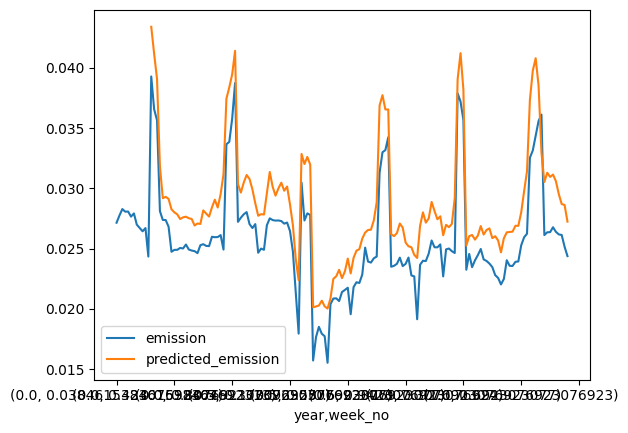

In [114]:
train_joined_v2.groupby(['year','week_no']).mean()[['emission','predicted_emission']].plot(kind='line')

- The predictions seem to fit the data patterns much better, but on average it seems like they are biased given that they tend to over-predict when averaging all locations. This are not great results either

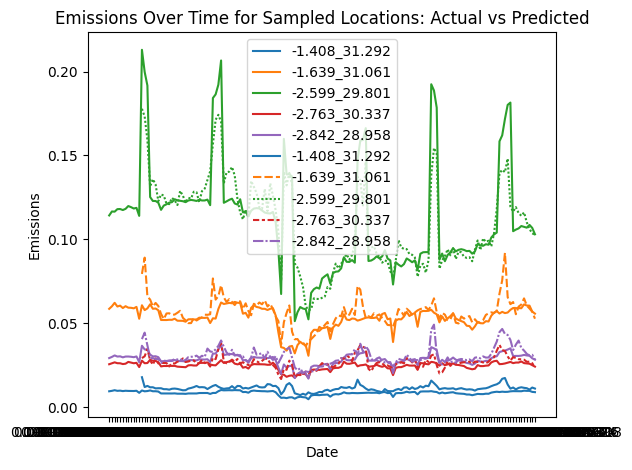

<Figure size 1400x1400 with 0 Axes>

In [117]:
sampled_locations = train_joined_v2['location'].sample(5).unique()
sampled_data = train_joined_v2[train_joined_v2['location'].isin(sampled_locations)]


sampled_data['date'] = sampled_data['year'].astype(str) + "-" + sampled_data['week_no'].astype(str)
# Plotting the actual emissions for the sampled locations
sns.lineplot(data=sampled_data, x='date', y='emission', hue='location', style='location', palette='tab10', dashes=False)

# Plotting the predicted emissions for the test period of the sampled locations
sns.lineplot(data=sampled_data, x='date', y='predicted_emission', hue='location', style='location', palette='tab10', dashes=True)


plt.title('Emissions Over Time for Sampled Locations: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()

plt.tight_layout()
plt.figure(figsize=(14, 14))

plt.show()

## Conclusions